**Executed:** Wed Jan 18 21:42:51 2017

**Duration:** 641 seconds.

In [1]:
measurement_id = 0 # possible values: 0, 1, 2
windows = (5, 30, 60)

In [2]:
# Cell inserted during automated execution.
windows = (5, 30, 60)
measurement_id = 1

### Notebook arguments

- **measurement_id** (*int*): Select the measurement. Valid values: 0, 1, 2.
- **windows** (*tuple of ints*): List of integration window durations (seconds).

# 8-spot kinetics

<p class="lead">This notebook executes the realtime-kinetics analysis.</p>

The first cell of this notebook selects which measurement is analyzed. 
Measurements can be processed one-by-one, by manually running this notebook,
or in batch by using the notebook: *"8-spot bubble-bubble kinetics - Run-All"*.

## Loading the software

In [3]:
import time
from pathlib import Path
import pandas as pd
from scipy.stats import linregress
from IPython.display import display

In [4]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.5.9).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [5]:
sns = init_notebook(fs=14)

In [6]:
import lmfit; lmfit.__version__

'0.9.5'

In [7]:
import phconvert; phconvert.__version__

'0.7.2'

# Selecting a data file

In [8]:
dir_ = 'data/multispot_'

filenames = [
    dir_+'2015-07-31_bubble-bubble-run-off-kinetics-800mW-steer110_12.hdf5',
    dir_+'2015-07-29_bubble-bubble-open-complex-run-off-kinetics-600mW-steer110_7.hdf5',
    dir_+'2015-07-30_bubble-bubble-run-off-kinetics-800mW-steer110_8.hdf5']

start_times = [900, 600, 900] # time of NTP injection and start of kinetics

In [9]:
filename = filenames[measurement_id]
start_time = start_times[measurement_id]

In [10]:
filename

'data/multispot_2015-07-29_bubble-bubble-open-complex-run-off-kinetics-600mW-steer110_7.hdf5'

In [11]:
import os
assert os.path.exists(filename)

## Data load and Burst search

Load and process the data:

In [12]:
d = loader.photon_hdf5(filename)

In [13]:
d.time_max

4376.4312615999997

Compute background and burst search:

In [14]:
d.calc_bg(bg.exp_fit, time_s=10, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... [DONE]


Perform a background plot as a function of the channel:

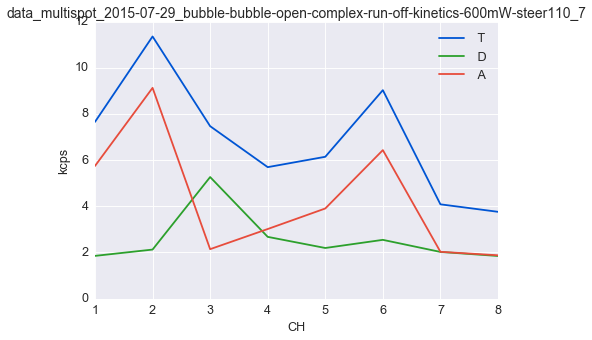

In [15]:
mch_plot_bg(d)

Let's take a look at the photon waiting times histograms and at the fitted background rates:

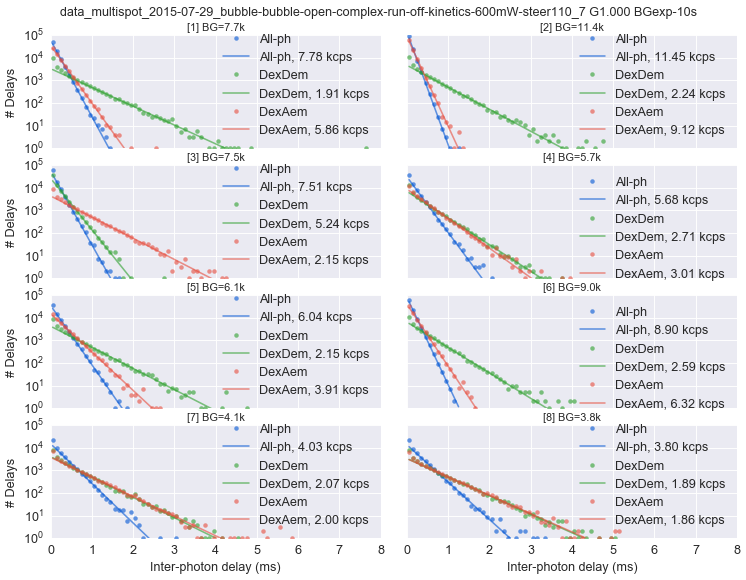

In [16]:
dplot(d, hist_bg);

Using `dplot` exactly in the same way as for the single-spot data has now generated 8 subplots, one for each channel.

Let's plot a timetrace for the background to see is there are significat variations during the measurement:

(450, 750)

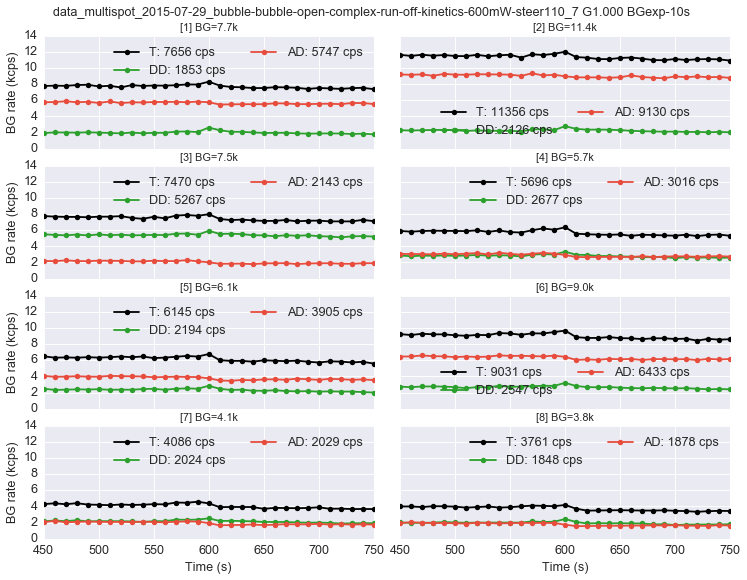

In [17]:
dplot(d, timetrace_bg);
xlim(start_time - 150, start_time + 150)

We can look at the timetrace of the photon stream (binning):

In [18]:
#dplot(d, timetrace)
#xlim(2, 3); ylim(-100, 100);

## Burst selection and FRET

In [19]:
d.burst_search(m=10, F=5)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   [DONE Counting D/A]


In [20]:
ds = d.select_bursts(select_bursts.size, th1=30)

### Selecting bursts by size

In [21]:
ds0 = ds.select_bursts(select_bursts.time, time_s1=0, time_s2=start_time-10)

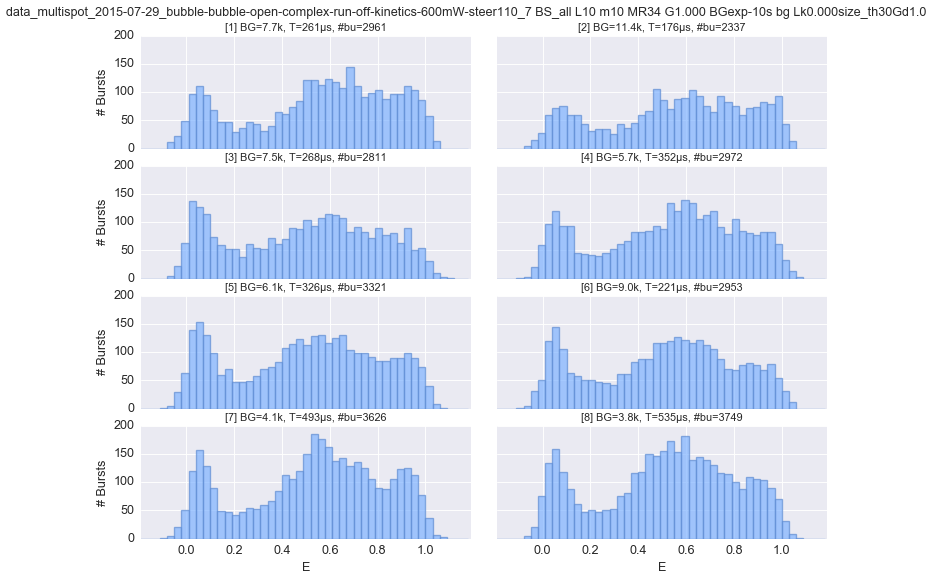

In [22]:
dplot(ds0, hist_fret, pdf=False);

In [23]:
dm0 = ds0.collapse()

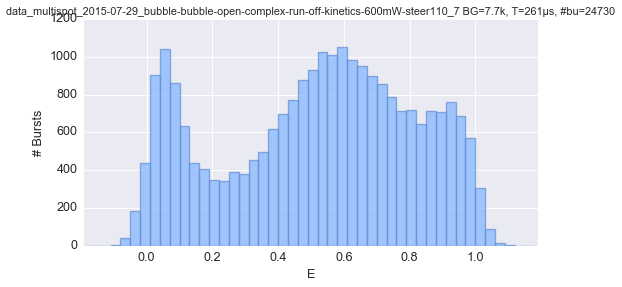

In [24]:
dplot(dm0, hist_fret, pdf=False);

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma,p3_amplitude,p3_center,p3_sigma
0,0.16224,0.0556736,0.0440433,0.754021,0.572731,0.191952,0.0840628,0.931055,0.056562


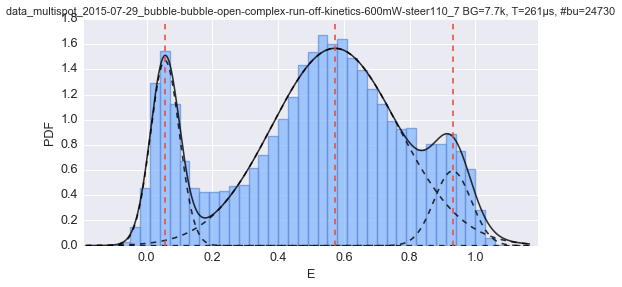

In [25]:
weights = 'size'
bext.bursts_fitter(dm0, weights=weights)
dm0.E_fitter.fit_histogram(mfit.factory_three_gaussians(p1_center=0.05, p2_center=0.6, p3_center=0.9), verbose=False)
dplot(dm0, hist_fret, show_model=True, weights=weights);
dm0.E_fitter.params

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma,p3_amplitude,p3_center,p3_sigma
0,0.187635,0.0623241,0.0578235,0.69977,0.582726,0.2,0.113725,0.928691,0.0634391


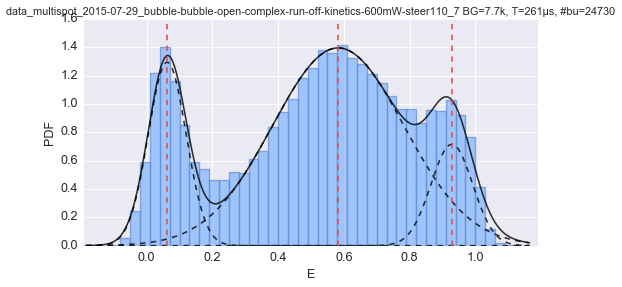

In [26]:
weights = None
bext.bursts_fitter(dm0, weights=weights)
dm0.E_fitter.fit_histogram(mfit.factory_three_gaussians(p1_center=0.05, p2_center=0.6, p3_center=0.9), verbose=False)
dplot(dm0, hist_fret, show_model=True, weights=weights);
dm0.E_fitter.params

## 3-Gaussian peaks

In [27]:
def gauss3(**params0):
    peak1 = lmfit.models.GaussianModel(prefix='p1_')
    peak3 = lmfit.models.GaussianModel(prefix='p3_')
    peak2 = lmfit.models.GaussianModel(prefix='p2_')
    model = peak1 + peak2 + peak3
    model.set_param_hint('p1_center', **{'value': 0.0, 'min': 0.0, 'max': 0.2, **params0.get('p1_center', {})})
    model.set_param_hint('p2_center', **{'value': 0.5, 'min': 0.0, 'max': 1.0, **params0.get('p2_center', {})})
    model.set_param_hint('p3_center', **{'value': 0.9, 'min': 0.8, 'max': 1.0, **params0.get('p3_center', {})})
    for sigma in ['p%d_sigma' % i for i in (1, 2, 3)]:
        model.set_param_hint(sigma, **{'value': 0.02, 'min': 0.01, **params0.get(sigma, {})})
    for ampl in ['p%d_amplitude' % i for i in (1, 2, 3)]:
        model.set_param_hint(ampl, **{'value': 0.333, 'min': 0.01, **params0.get(ampl, {})})
    model.name = '3 gauss peaks'
    return model

In [28]:
#%matplotlib notebook

In [29]:
#fig, ax = plt.subplots(figsize=(12, 8))
#dplot(dm0, scatter_fret_size, ax=ax)

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma,p3_amplitude,p3_center,p3_sigma
0,0.177976,0.0604911,0.0552007,0.744359,0.589284,0.218171,0.0888657,0.933395,0.0557688


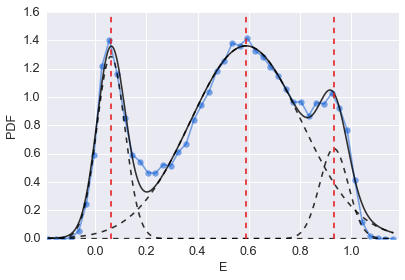

In [30]:
bext.bursts_fitter(dm0, weights=None)
dm0.E_fitter.fit_histogram(gauss3(), verbose=False)
mfit.plot_mfit(dm0.E_fitter)
params_3gauss = dm0.E_fitter.params
plt.xlabel('E')
plt.ylabel('PDF')
plt.title('')
#dir_ = r'C:\Data\Antonio\docs\conferences\Seaborg2015\figures/'
#plt.savefig(dir_+'Realtime kinetics FRET hist', dpi=200, bbox_inches='tight')
params_3gauss

In [31]:
dsc = ds.collapse()

In [32]:
dm_final = dsc.select_bursts(select_bursts.time, time_s1=start_time+300, time_s2=ds.time_max + 1)
dm_final.num_bursts

array([121848])

In [33]:
dm_final1 = dsc.select_bursts(select_bursts.time, time_s1=start_time+100, time_s2=start_time+1600)
dm_final1.num_bursts

array([40240])

In [34]:
dm_final2 = dsc.select_bursts(select_bursts.time, time_s1=start_time + 2100, time_s2=ds.time_max + 1)
dm_final2.num_bursts

array([68005])

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma,p3_amplitude,p3_center,p3_sigma
0,0.296566,0.0631328,0.0540374,0.353144,0.589284,0.284748,0.371389,0.932516,0.0622702


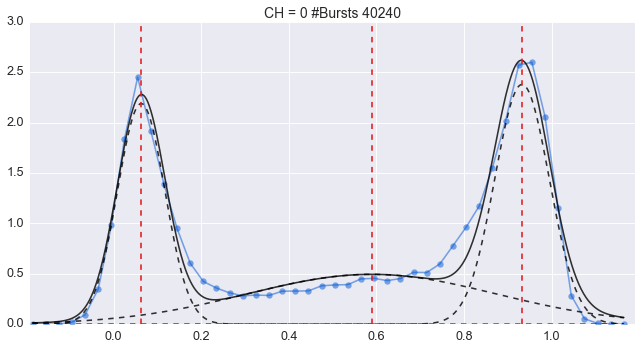

In [35]:
bext.bursts_fitter(dm_final1, weights=None)
model = gauss3()
model.set_param_hint('p2_center', value=params_3gauss.p2_center[0], vary=False)
dm_final1.E_fitter.fit_histogram(model, verbose=False)
fig, ax = plt.subplots(figsize=(12, 6))
mfit.plot_mfit(dm_final1.E_fitter, ax=ax)
params_3gauss1 = dm_final1.E_fitter.params
params_3gauss1

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma,p3_amplitude,p3_center,p3_sigma
0,0.282824,0.0605216,0.0545922,0.373898,0.589284,0.265045,0.359364,0.929698,0.0630971


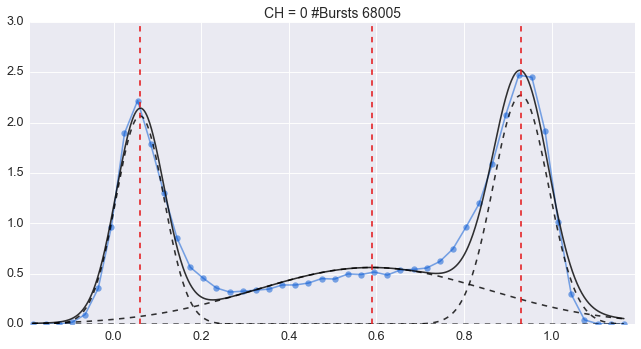

In [36]:
bext.bursts_fitter(dm_final2, weights=None)
model = gauss3()
model.set_param_hint('p2_center', value=params_3gauss.p2_center[0], vary=False)
dm_final2.E_fitter.fit_histogram(model, verbose=False)
fig, ax = plt.subplots(figsize=(12, 6))
mfit.plot_mfit(dm_final2.E_fitter, ax=ax)
params_3gauss1 = dm_final2.E_fitter.params
params_3gauss1

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma,p3_amplitude,p3_center,p3_sigma
0,0.293309,0.0615472,0.056712,0.354943,0.589284,0.261796,0.369835,0.929968,0.0634752


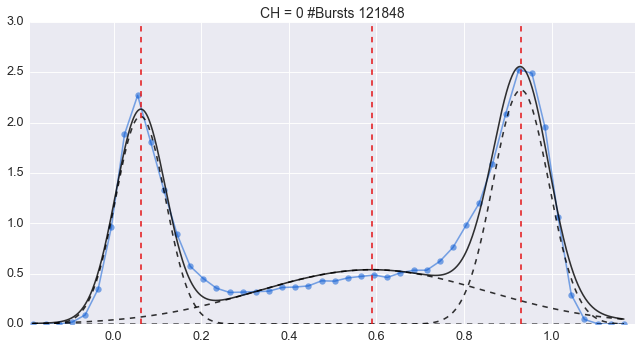

In [37]:
bext.bursts_fitter(dm_final, weights=None)
model = gauss3()
model.set_param_hint('p2_center', value=params_3gauss.p2_center[0], vary=False)
dm_final.E_fitter.fit_histogram(model, verbose=False)
fig, ax = plt.subplots(figsize=(12, 6))
mfit.plot_mfit(dm_final.E_fitter, ax=ax)
params_3gauss1 = dm_final.E_fitter.params
params_3gauss1

In [38]:
#del params_3gauss0

In [39]:
if 'params_3gauss0' not in locals():
    params_3gauss0 = params_3gauss.copy()
    params_3gauss0.p3_center = params_3gauss1.p3_center

In [40]:
params_3gauss0.p1_amplitude + params_3gauss0.p2_amplitude + params_3gauss0.p3_amplitude

0    1.0112
dtype: object

In [41]:
'params_3gauss0' in locals()

True

# Fit

In [42]:
from scipy import optimize

In [43]:
params_fixed = dict(
    mu1=float(params_3gauss0.p1_center),
    mu2=float(params_3gauss0.p2_center),
    mu3=float(params_3gauss0.p3_center),
    sig1=float(params_3gauss0.p1_sigma),
    sig2=float(params_3gauss0.p2_sigma),
    sig3=float(params_3gauss0.p3_sigma),
)

In [44]:
def em_weights_3gauss(x, a2, a3, mu1, mu2, mu3, sig1, sig2, sig3):
    """Responsibility function for a 3-Gaussian model.
    
    Returns 3 arrays of size = x.size: the responsibility of 
    each Gaussian population.
    """
    a1 = 1 - a2 - a3
    assert np.abs(a1 + a2 + a3 - 1) < 1e-3
    f1 = a1 * gauss_pdf(x, mu1, sig1)
    f2 = a2 * gauss_pdf(x, mu2, sig2)
    f3 = a3 * gauss_pdf(x, mu3, sig3)
    γ1 = f1 / (f1 + f2 + f3)
    γ2 = f2 / (f1 + f2 + f3)
    γ3 = f3 / (f1 + f2 + f3)
    return γ1, γ2, γ3

def em_fit_3gauss(x, a2_0, a3_0, params_fixed, print_every=10, max_iter=100, rtol=1e-3):
    """Fit amplitude of 3_Gaussian model using Expectation-Maximization.
    
    Only 2 amplitudes are fitted (a2, a3), the first peak is derived imposing
    that the PDF sums to 1.
    """
    a2_new, a3_new = a2_0, a3_0
    rel_change = 1
    i = 0
    while rel_change > rtol and i < max_iter:

        # E-step
        γ1, γ2, γ3 = em_weights_3gauss(x, a2_new, a3_new, **params_fixed)
        assert np.allclose(γ1.sum() + γ2.sum() + γ3.sum(), x.size)

        # M-step
        a2_old, a3_old = a2_new, a3_new     
        a2_new = γ2.sum()/γ2.size
        a3_new = γ3.sum()/γ3.size

        # Convergence
        rel_change = (np.abs((a2_old - a2_new)/a2_new)
                      + np.abs((a3_old - a3_new)/a3_new))
        i += 1
        if (i % print_every) == 0:
            print(i, a2_new, a3_new, rel_change)
        
    return a2_new, a3_new, i

In [45]:
from matplotlib.pylab import normpdf as gauss_pdf

# Model PDF to be maximized
def model_pdf(x, a2, a3, mu1, mu2, mu3, sig1, sig2, sig3):
    a1 = 1 - a2 - a3
    #assert np.abs(a1 + a2 + a3 - 1) < 1e-3
    return (a1 * gauss_pdf(x, mu1, sig1) + 
            a2 * gauss_pdf(x, mu2, sig2) + 
            a3 * gauss_pdf(x, mu3, sig3))

# Function to be minimized by lmfit
def func2min_lmfit(params, x):
    a2 = params['a2'].value
    a3 = params['a3'].value
    mu1 = params['mu1'].value
    mu2 = params['mu2'].value
    mu3 = params['mu3'].value
    sig1 = params['sig1'].value
    sig2 = params['sig2'].value
    sig3 = params['sig3'].value
    return -np.sqrt(np.log(model_pdf(x, a2, a3, mu1, mu2, mu3, sig1, sig2, sig3)))

# Function to be minimized by scipy
def func2min_scipy(params_fit, params_fixed, x):
    a2, a3 = params_fit
    mu1 = params_fixed['mu1']
    mu2 = params_fixed['mu2']
    mu3 = params_fixed['mu3']
    sig1 = params_fixed['sig1']
    sig2 = params_fixed['sig2']
    sig3 = params_fixed['sig3']
    return -np.log(model_pdf(x, a2, a3, mu1, mu2, mu3, sig1, sig2, sig3)).sum()

# create a set of Parameters
params = lmfit.Parameters()
params.add('a2', value=0.33, min=0)
params.add('a3', value=0.33, min=0)
for k, v in params_fixed.items():
    params.add(k, value=v, vary=False)

$$f(x) = \frac{A}{\sigma\sqrt{2\pi}}\, e^{-\frac{(x - \mu)^2}{2 \sigma^2}}$$

$$\log f(x) = \log \frac{A}{\sigma\sqrt{2\pi}}\, e^{-\frac{(x - \mu)^2}{2 \sigma^2}} = \log{A} -\log{\sigma} - \log\sqrt{2\pi} -\frac{(x - \mu)^2}{2 \sigma^2}$$

$$w_1 \; f_1(x) + w_2 \; f_2(x) + w_3 \; f_3(x)$$

$$\log (w_1 \; f_1(x)) = \log{w_1} + \log{f_1(x)}$$


In [46]:
x = dm0.E_
x

#result = lmfit.minimize(func2min_lmfit, params, args=(x,), method='nelder')
#lmfit.report_fit(result.params)

array([ 0.23554868,  0.07878577,  0.61248984, ...,  0.96548449,
        0.2661022 ,  0.25448072])

In [47]:
#optimize.brute(func2min_scipy, ranges=((0.01, 0.99), (0.01, 0.99)), Ns=101, args=(params, x))

In [48]:
res = optimize.minimize(func2min_scipy, x0=[0.33, 0.33], args=(params_fixed, x), method='Nelder-Mead')
res

 final_simplex: (array([[ 0.73531686,  0.08906544],
       [ 0.73529147,  0.0890564 ],
       [ 0.73527623,  0.08909188]]), array([ 1172.02880781,  1172.02881774,  1172.02883107]))
           fun: 1172.028807811053
       message: 'Optimization terminated successfully.'
          nfev: 72
           nit: 38
        status: 0
       success: True
             x: array([ 0.73531686,  0.08906544])

In [49]:
res = optimize.minimize(func2min_scipy, x0=[0.33, 0.33], args=(params_fixed, x), bounds=((0,1), (0,1)), method='SLSQP')
res

     fun: 1172.0287875366655
     jac: array([-0.08081055, -0.02848816,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 41
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 0.73529794,  0.08906745])

In [50]:
res = optimize.minimize(func2min_scipy, x0=[0.33, 0.33], args=(params_fixed, x), bounds=((0,1), (0,1)), method='TNC')
res

     fun: 1172.0287875066938
     jac: array([ 0.00022737,  0.00031832])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 48
     nit: 13
  status: 1
 success: True
       x: array([ 0.73529879,  0.08906713])

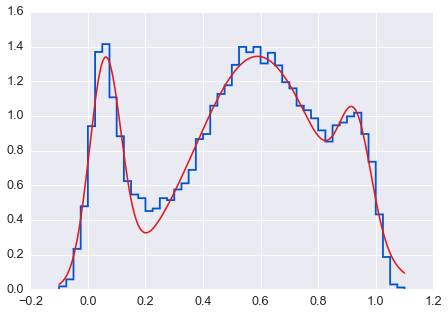

In [51]:
bins = np.arange(-0.1, 1.1, 0.025)
plt.hist(x, bins, histtype='step', lw=2, normed=True);
xx = np.arange(-0.1, 1.1, 0.005)
#plt.plot(xx, model_pdf(xx, params))
plt.plot(xx, model_pdf(xx, a2=res.x[0], a3=res.x[1], **params_fixed))

# Kinetics

## Definitions

In [52]:
def _kinetics_fit_em(dx, a2_0, a3_0, params_fixed, **kwargs):
    kwargs = {'max_iter': 200, 'print_every': 201, **kwargs}
    a2, a3, i = em_fit_3gauss(dx.E_, a2_0, a3_0, params_fixed, **kwargs)
    return a2, a3, i < kwargs['max_iter']

def _kinetics_fit_ll(dx, a2_0, a3_0, params_fixed, **kwargs):
    kwargs = {'method':'Nelder-Mead', **kwargs}
    res = optimize.minimize(func2min_scipy, x0=[a2_0, a3_0], args=(params_fixed, dx.E_), 
                            **kwargs)
    return res.x[0], res.x[1], res.success
    
def _kinetics_fit_hist(dx, a2_0, a3_0, params_fixed):
    E_fitter = bext.bursts_fitter(dx)
    model = gauss3(p1_amplitude={'value': 1 - a2_0 - a3_0}, 
                   p2_amplitude={'value': a2_0}, 
                   p3_amplitude={'value': a3_0})
    model.set_param_hint('p1_center', value=params_fixed['mu1'], vary=False)
    model.set_param_hint('p2_center', value=params_fixed['mu2'], vary=False)
    model.set_param_hint('p3_center', value=params_fixed['mu3'], vary=False)
    model.set_param_hint('p1_sigma', value=params_fixed['sig1'], vary=False)
    model.set_param_hint('p2_sigma', value=params_fixed['sig2'], vary=False)
    model.set_param_hint('p3_sigma', value=params_fixed['sig3'], vary=False)    
    E_fitter.fit_histogram(model, verbose=False)
    return (float(E_fitter.params.p2_amplitude), 
            float(E_fitter.params.p3_amplitude), 
            dx.E_fitter.fit_res[0].success)
    
def kinetics_fit(ds_slices, params_fixed, a2_0=0.33, a3_0=0.33, method='em', **method_kws):
    fit_func = {
        'em': _kinetics_fit_em, 
        'll': _kinetics_fit_ll,
        'hist': _kinetics_fit_hist}
    
    fit_list = []
    for dx in ds_slices:
        a2, a3, success = fit_func[method](dx, a2_0, a3_0, params_fixed, **method_kws)
        df_i = pd.DataFrame(data=dict(p2_amplitude=a2, p3_amplitude=a3, 
                                      p1_center=params_fixed['mu1'], p2_center=params_fixed['mu2'], 
                                      p3_center=params_fixed['mu3'], p1_sigma=params_fixed['sig1'],
                                      p2_sigma=params_fixed['sig2'], p3_sigma=params_fixed['sig3'],
                                      tstart=dx.slice_tstart, tstop=dx.slice_tstop, 
                                      tmean=0.5*(dx.slice_tstart + dx.slice_tstop)), 
                            index=[0.5*(dx.slice_tstart + dx.slice_tstop)])
        if not success:
            print('* ', end='', flush=True)
            continue 
        fit_list.append(df_i)
    return pd.concat(fit_list)

In [53]:
start_time/60

10.0

## Moving-window processing

In [54]:
def print_slices(moving_window_params):
    msg = ' - Slicing measurement:'
    for name in ('start', 'stop', 'step', 'window'):
        msg += ' %s = %.1fs' % (name, moving_window_params[name]) 
    print(msg, flush=True)
    num_slices = len(bext.moving_window_startstop(**moving_window_params))
    print('   Number of slices %d' % num_slices, flush=True)

In [55]:
t1 = time.time()
time.ctime()

'Wed Jan 18 21:47:07 2017'

In [56]:
dsc = ds.collapse()
dsc.calc_max_rate(m=10)
dsc_high = dsc.select_bursts(select_bursts.E, E1=0.88)

In [57]:
step = 1
params = {}
for window in windows:
    moving_window_params = dict(start=0, stop=dsc.time_max, step=step, window=window)
    print_slices(moving_window_params)

    ds_slices = bext.moving_window_chunks(dsc, time_zero=start_time, **moving_window_params)
    for meth in ['em', 'll', 'hist']:
        print('    >>> Fitting method %s ' % meth, end='', flush=True)
        p = kinetics_fit(ds_slices, params_fixed, method=meth)
        print(flush=True)
        p['kinetics'] = p.p3_amplitude / (p.p2_amplitude + p.p3_amplitude)
        p = p.round(dict(p1_center=3, p1_sigma=4, p2_amplitude=4, p2_center=3, p2_sigma=4, kinetics=4,
                         p3_amplitude=4, p3_center=3, p3_sigma=4))
        params[meth, window, step] = p

 - Slicing measurement: start = 0.0s stop = 4376.4s step = 1.0s window = 5.0s
   Number of slices 4372
    >>> Fitting method em * * * * * * * * * * * * * * * 

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in double_scalars
/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in double_scalars


* 
    >>> Fitting method ll 

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in log


* 
    >>> Fitting method hist 
 - Slicing measurement: start = 0.0s stop = 4376.4s step = 1.0s window = 30.0s
   Number of slices 4347
    >>> Fitting method em 
    >>> Fitting method ll 
    >>> Fitting method hist 
 - Slicing measurement: start = 0.0s stop = 4376.4s step = 1.0s window = 60.0s
   Number of slices 4317
    >>> Fitting method em 
    >>> Fitting method ll 
    >>> Fitting method hist 


In [58]:
print('Moving-window processing duration: %d seconds.' % (time.time() - t1))

Moving-window processing duration: 371 seconds.


## Burst-data

In [59]:
moving_window_params['window'] = 30
moving_window_params

{'start': 0, 'step': 1, 'stop': 4376.4312615999997, 'window': 30}

In [60]:
ds_slices = bext.moving_window_chunks(dsc, **moving_window_params)
ds_slices_high = bext.moving_window_chunks(dsc_high, **moving_window_params)

df = bext.moving_window_dataframe(**moving_window_params) - start_time
df['size_mean'] = [di.nt_.mean() for di in ds_slices]
df['size_max'] = [di.nt_.max() for di in ds_slices]
df['num_bursts'] = [di.num_bursts[0] for di in ds_slices]
df['burst_width'] = [di.mburst_.width.mean()*di.clk_p*1e3 for di in ds_slices]
df['burst_width_high'] = [di.mburst_.width.mean()*di.clk_p*1e3 for di in ds_slices_high]
df['phrate_mean'] = [di.max_rate_.mean() for di in ds_slices]

In [61]:
df = df.round(dict(tmean=1, tstart=1, tstop=1, size_mean=2, size_max=1, 
                   burst_width=2, burst_width_high=2, phrate_mean=1))
df

,tmean,tstart,tstop,size_mean,size_max,num_bursts,burst_width,burst_width_high,phrate_mean
0,-585.0,-600.0,-570.0,77.25,827.1,1119,1.53,1.52,46623.6
1,-584.0,-599.0,-569.0,76.69,827.1,1130,1.52,1.47,47215.2
2,-583.0,-598.0,-568.0,76.76,827.1,1122,1.52,1.46,44348.5
3,-582.0,-597.0,-567.0,75.21,687.7,1124,1.50,1.39,44441.4
4,-581.0,-596.0,-566.0,75.08,687.7,1142,1.51,1.36,41303.8
...,...,...,...,...,...,...,...,...,...
4342,3757.0,3742.0,3772.0,70.87,891.4,1252,1.35,1.23,NaN
4343,3758.0,3743.0,3773.0,71.32,891.4,1276,1.35,1.25,NaN
4344,3759.0,3744.0,3774.0,70.46,891.4,1302,1.34,1.24,NaN
4345,3760.0,3745.0,3775.0,70.17,891.4,1313,1.35,1.24,NaN


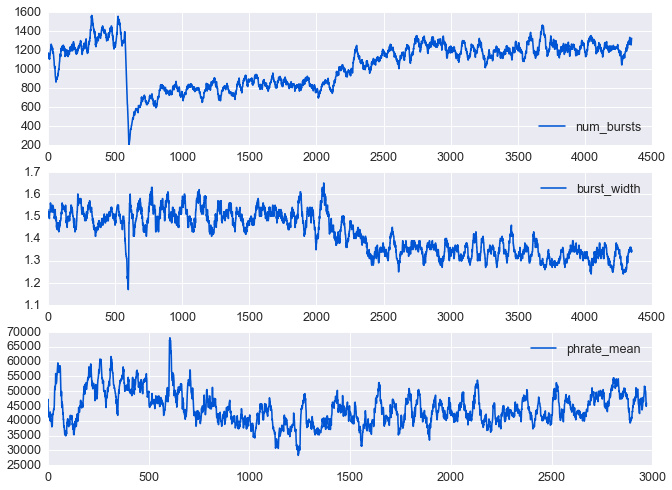

In [62]:
labels = ('num_bursts', 'burst_width', 'phrate_mean')
fig, axes = plt.subplots(len(labels), 1, figsize=(12, 3*len(labels)))

for ax, label in zip(axes, labels):
    ax.plot(label, data=df)
    ax.legend(loc='best')
    #ax.set_ylim(0)

In [63]:
# %%timeit -n1 -r1
# meth = 'em'
# print('    >>> Fitting method %s' % meth, flush=True)
# p = kinetics_fit(ds_slices, params_fixed, method=meth)

In [64]:
# %%timeit -n1 -r1
# meth = 'hist'
# print('    >>> Fitting method %s' % meth, flush=True)
# p = kinetics_fit(ds_slices, params_fixed, method=meth)

In [65]:
# %%timeit -n1 -r1
# meth = 'll'
# print('    >>> Fitting method %s' % meth, flush=True)
# p = kinetics_fit(ds_slices, params_fixed, method=meth)

In [66]:
out_fname = 'results/%s_burst_data_vs_time__window%ds_step%ds.csv' % (
    Path(filename).stem, moving_window_params['window'], moving_window_params['step'])
out_fname

'results/multispot_2015-07-29_bubble-bubble-open-complex-run-off-kinetics-600mW-steer110_7_burst_data_vs_time__window30s_step1s.csv'

In [67]:
df.to_csv(out_fname)

## Population fraction

In [68]:
# np.abs((params['em', 30, 1]  - params['ll', 30, 1]).p2_amplitude).max()

In [69]:
methods = ('em', 'll', 'hist')

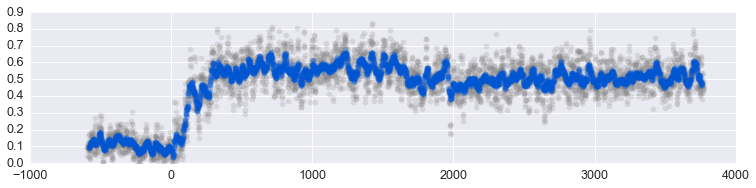

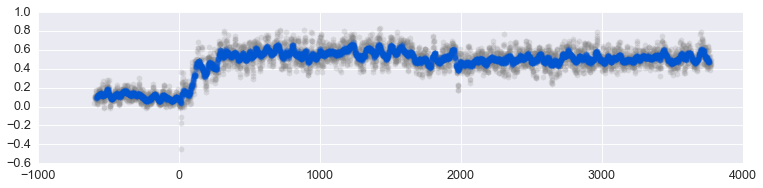

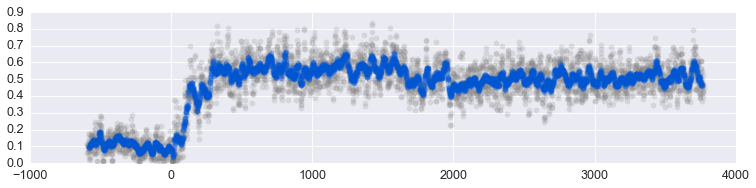

In [70]:
for meth in methods:
    plt.figure(figsize=(14, 3))
    plt.plot(params[meth, 5, 1].index, params[meth, 5, 1].kinetics, 'h', color='gray', alpha=0.2)
    plt.plot(params[meth, 30, 1].index, params[meth, 30, 1].kinetics, 'h', alpha=0.3)

In [71]:
# (params['em', 5, 1].kinetics - params['ll', 5, 1].kinetics).plot()

In [72]:
step = 1
for window in windows:
    for meth in methods:
        out_fname = ('results/' + Path(filename).stem + 
                     '_%sfit_ampl_only__window%ds_step%ds.csv' % (meth, window, step))
        print('- Saving: ', out_fname)
        params[meth, window, step].to_csv(out_fname)

- Saving:  results/multispot_2015-07-29_bubble-bubble-open-complex-run-off-kinetics-600mW-steer110_7_emfit_ampl_only__window5s_step1s.csv
- Saving:  results/multispot_2015-07-29_bubble-bubble-open-complex-run-off-kinetics-600mW-steer110_7_llfit_ampl_only__window5s_step1s.csv
- Saving:  results/multispot_2015-07-29_bubble-bubble-open-complex-run-off-kinetics-600mW-steer110_7_histfit_ampl_only__window5s_step1s.csv
- Saving:  results/multispot_2015-07-29_bubble-bubble-open-complex-run-off-kinetics-600mW-steer110_7_emfit_ampl_only__window30s_step1s.csv
- Saving:  results/multispot_2015-07-29_bubble-bubble-open-complex-run-off-kinetics-600mW-steer110_7_llfit_ampl_only__window30s_step1s.csv
- Saving:  results/multispot_2015-07-29_bubble-bubble-open-complex-run-off-kinetics-600mW-steer110_7_histfit_ampl_only__window30s_step1s.csv
- Saving:  results/multispot_2015-07-29_bubble-bubble-open-complex-run-off-kinetics-600mW-steer110_7_emfit_ampl_only__window60s_step1s.csv
- Saving:  results/multisp

In [73]:
d

data_multispot_2015-07-29_bubble-bubble-open-complex-run-off-kinetics-600mW-steer110_7 BS_all L10 m10 MR34 G1.000 BGexp-10s bg Lk0.000